## Apprentissage : 

### Validation croisée sur le modèle de Random Forest

    --  entrainement : années 2019_2020 , 2020_2021 , 2021_2022

    -- test : 2022_2023



In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler

In [65]:
# chemin vers les données
path = "/scratch/labia/tchoffoc/donnees_mises_en_forme/" 

# lire les fichiers CSV dans le path 
df0 = pd.read_csv(path + "donnees_fichiers_grib_2019_2020.csv")
df1 = pd.read_csv(path + "donnees_fichiers_grib_2020_2021.csv")
df2 = pd.read_csv(path + "donnees_fichiers_grib_2021_2022.csv")
df3 = pd.read_csv(path + "donnees_fichiers_grib_2022_2023.csv")
y = pd.read_csv(path + "donnees_obs_predicteurs_temporels_gelee_blanche.csv")

In [57]:
# Concaténer les DataFrames df0, df1 df2 , df3  en un seul DataFrame df_final , pas de colonne d'index , et supprimer la colonne : 'Unnamed: 0'
df_final = pd.concat([df0, df1, df2, df3], ignore_index=True)

# Fusionner les DataFrames df_final et y en utilisant la colonne "date" comme clé de fusion , pas de colonne d'index
df_merged = pd.merge(df_final, y, on="date", how="inner")

# supprimer les lignes avec des valeurs manquantes
df_merged = df_merged.dropna() 

# Calculer la nouvelle colonne représentant la norme du vent
df_merged['vent'] = np.sqrt(df_merged['u10']**2 + df_merged['v10']**2)
# Supprimer les colonnes u10 et v10
#df_merged.drop(['u10', 'v10'], axis=1, inplace=True)


In [66]:
# selection des données d'entrainement et de test (X_train , X_test , y_train , y_test) : l'entrainement c'est les dates entre 01/10/2019 et 31/05/2022 et le test c'est les dates entre 01/10/2022 et 31/05/2023
X_train = df_merged.loc[(df_merged["date"] >= "2019-10-01") & (df_merged["date"] <= "2022-05-31")].drop(["date", "gelee_blanche_vehicule_presence","u10","v10"], axis=1)
X_test = df_merged.loc[(df_merged["date"] >= "2022-10-01") & (df_merged["date"] <= "2023-05-31")].drop(["date", "gelee_blanche_vehicule_presence","u10","v10"], axis=1)
y_train = df_merged.loc[(df_merged["date"] >= "2019-10-01") & (df_merged["date"] <= "2022-05-31"), "gelee_blanche_vehicule_presence"]
y_test = df_merged.loc[(df_merged["date"] >= "2022-10-01") & (df_merged["date"] <= "2023-05-31"), "gelee_blanche_vehicule_presence"]

## Nombre d'épisodes de gelée blanche par an

annee
2019    143
2020    308
2021    504
2022    461
2023    270
Name: gelee_blanche_vehicule_presence, dtype: int64


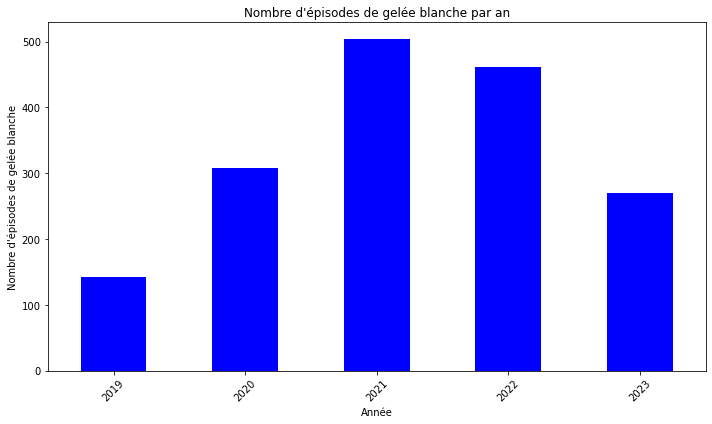

In [67]:
# Convertir la colonne 'date' en format de date
df_merged['date'] = pd.to_datetime(df_merged['date'])

# Extraire l'année à partir de la colonne 'date'
df_merged['annee'] = df_merged['date'].dt.year

# Grouper par année et compter le nombre d'épisodes de gelée blanche (valeur 1)
episodes_par_an = df_merged.groupby('annee')['gelee_blanche_vehicule_presence'].sum()
print(episodes_par_an)
# Créer un graphique à barres
plt.figure(figsize=(10, 6))
episodes_par_an.plot(kind='bar', color='blue')
plt.title("Nombre d'épisodes de gelée blanche par an")
plt.xlabel('Année')
plt.ylabel("Nombre d'épisodes de gelée blanche")
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()


## Nombre d'épisodes de gelée blanche par ensemble de données


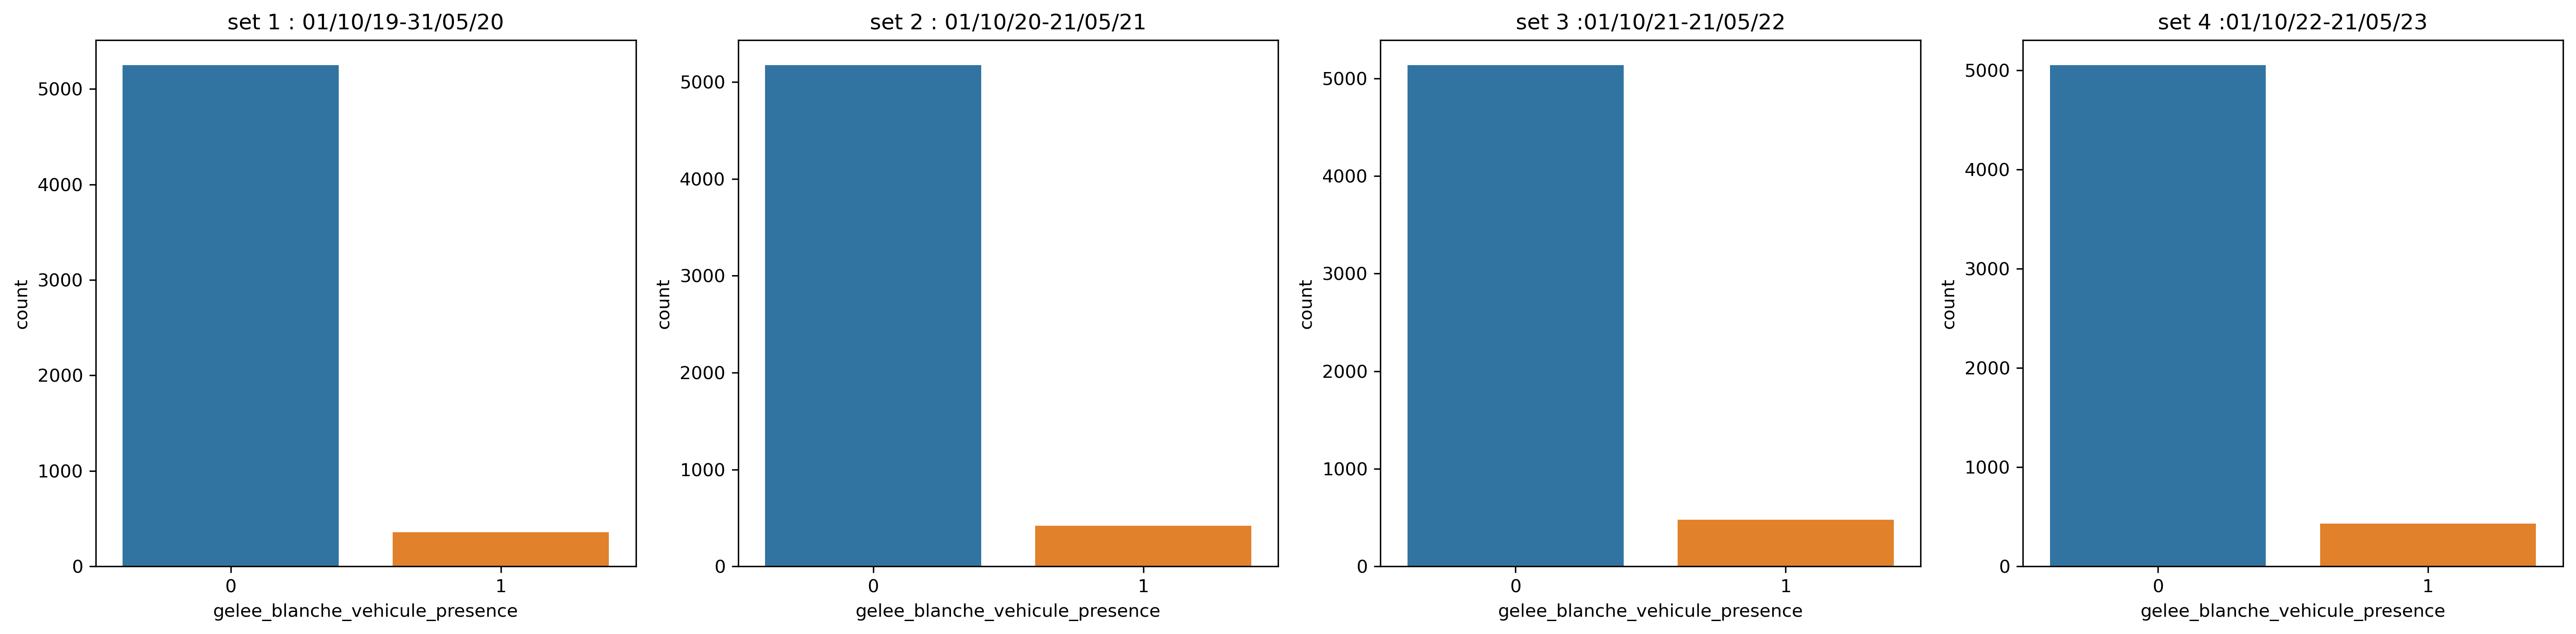

In [68]:
df_merged0 = pd.merge(df0, y, on="date", how="inner")
df_merged1 = pd.merge(df1, y, on="date", how="inner")
df_merged2 = pd.merge(df2, y, on="date", how="inner")
df_merged3 = pd.merge(df3, y, on="date", how="inner")
# Créer une seule figure et des sous-graphiques (axes) pour les quatre graphiques
fig, axes = plt.subplots(1, 4, figsize=(20, 5),dpi=300)

# Liste des DataFrames fusionnés
df_merged_list = [df_merged0, df_merged1, df_merged2, df_merged3]

# Noms correspondants aux DataFrames
df_names = ['set 1 : 01/10/19-31/05/20', 'set 2 : 01/10/20-21/05/21', 'set 3 :01/10/21-21/05/22', 'set 4 :01/10/22-21/05/23']

# Tracer chaque graphique
for i, (df, name) in enumerate(zip(df_merged_list, df_names)):
    sns.countplot(x='gelee_blanche_vehicule_presence', data=df, ax=axes[i])
    axes[i].set_title(name)

# Ajuster les espacements entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique combiné
plt.show()

## Optimisation des hyperparamètres avec GridSearchCV

In [ ]:
'''

Meilleurs hyperparamètres : 
        {'class_weight': {0: 1, 1: 2},
         'min_samples_leaf': 2, 
         'n_estimators': 300, 
         'n_jobs': 10}
pour maximiser la précision sur la classe 1 

'''
from sklearn.metrics import make_scorer, f1_score

# Créer un modèle Random Forest
model = RandomForestClassifier()

# Définir une grille de valeurs pour les hyperparamètres à tester

param_grid = {
    'n_jobs': [10],
    'class_weight': [{0: 1, 1: 2},{0: 1, 1: 5},{0: 1, 1: 10}, {0: 1, 1: 25}, {0: 1, 1: 50},{0: 1, 1: 75},{0: 1, 1: 100}],
    'min_samples_leaf': [2,5,10, 25, 50],
    'n_estimators': [5,10,25,50,100,200,300,400,500]
}


# Créer une instance de KFold avec 3 plis pour la validation croisée
kfold = KFold(n_splits=3)


# Créer l'objet GridSearchCV pour effectuer la recherche par validation croisée
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring=make_scorer(precision_score, pos_label=1))

# Entraîner le modèle avec la recherche par validation croisée
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Obtenir le meilleur modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_

# Faire des prédictions sur les données de test avec le meilleur modèle
y_pred = best_model.predict(X_test)

print('-------------------------------------------------------------------------------------------------------------------')
print("\n")


# Afficher le rapport de classification pour le meilleur modèle sur les données de test 
print(classification_report(y_test, y_pred))

# Ensembles de données pour l'entrainement

In [69]:
df_merged0 = pd.merge(df0, y, on="date", how="inner")
df_merged0['vent'] = np.sqrt(df_merged0['u10']**2 + df_merged0['v10']**2)

df_merged1 = pd.merge(df1, y, on="date", how="inner")
df_merged1['vent'] = np.sqrt(df_merged1['u10']**2 + df_merged1['v10']**2)

df_merged2 = pd.merge(df2, y, on="date", how="inner")
df_merged2['vent'] = np.sqrt(df_merged2['u10']**2 + df_merged2['v10']**2)


concatenated_df0 = pd.concat([df_merged0, df_merged1], axis=0)
concatenated_df0 = concatenated_df0.reset_index(drop=True)

concatenated_df1 = pd.concat([df_merged1, df_merged2], axis=0)
concatenated_df1 = concatenated_df1.reset_index(drop=True)


concatenated_df2 = pd.concat([df_merged0, df_merged2], axis=0)
concatenated_df2 = concatenated_df2.reset_index(drop=True)


## Notre validation croisée pour l'optimisation des hyperparamètres

In [70]:
# Sélection des colonnes à utiliser tout sauf 'date' et 'gelee_blanche_vehicule_presence'
features = [col for col in df_merged0.columns if col not in ["date", "gelee_blanche_vehicule_presence","u10","v10"]]

# Définir les hyperparamètres à tester
class_weight_options = [{0: 1, 1: 5},{0: 1, 1: 10},{0: 1, 1: 20},{0: 1, 1: 25},{0: 1, 1: 30}]
min_samples_leaf_options = [2, 5, 8, 10, 25, 50, 75, 100]
n_estimators_options = [100, 200, 300, 400, 500]

# Liste pour stocker les résultats des scores
results = []

# Boucle pour les combinaisons de données et d'hyperparamètres
for cw in class_weight_options:
    for msl in min_samples_leaf_options:
        for ne in n_estimators_options:
            all_y_true = []
            all_y_pred = []
            
            # Boucle pour les combinaisons de données d'entraînement et de test
            for train_num, (train_df, test_df) in enumerate([(concatenated_df0, df_merged2), (concatenated_df1, df_merged0), (concatenated_df2, df_merged1)], start=1):
                # Préparation des données
                X_train_e = train_df[features]
                y_train_e = train_df["gelee_blanche_vehicule_presence"]
                X_test_e = test_df[features]
                y_test_e = test_df["gelee_blanche_vehicule_presence"]

                # Création du modèle
                model = RandomForestClassifier(n_jobs=10, class_weight=cw, min_samples_leaf=msl, n_estimators=ne)
                model.fit(X_train_e, y_train_e)
                
                # Prédiction sur l'ensemble de test
                y_pred_e = model.predict(X_test_e)
                
                # Stockage des vraies valeurs et des prédictions
                all_y_true.extend(y_test_e)
                all_y_pred.extend(y_pred_e)
            
            # Calcul des scores pour cette combinaison d'hyperparamètres
            accuracy = accuracy_score(all_y_true, all_y_pred)
            recall = recall_score(all_y_true, all_y_pred, pos_label=1)
            f1 = f1_score(all_y_true, all_y_pred, pos_label=1)
            precision = precision_score(all_y_true, all_y_pred, pos_label=1)
            
            # Stockage des scores pour cette combinaison d'hyperparamètres
            results.append([cw, msl, ne, accuracy, recall, f1, precision])

# Créer un DataFrame contenant les scores
score_columns = ["class_weight", "min_samples_leaf", "n_estimators", "Accuracy", "Recall", "F1", "Precision"]
score_df = pd.DataFrame(results, columns=score_columns)
score_df['class_weight'] = score_df['class_weight'].astype(str)

In [ ]:
# faire de même pour la précision : 
#score_df[score_df.Precision >= (score_df.Precision.max()-0.1)].head(2)


## Influence du n_estimators

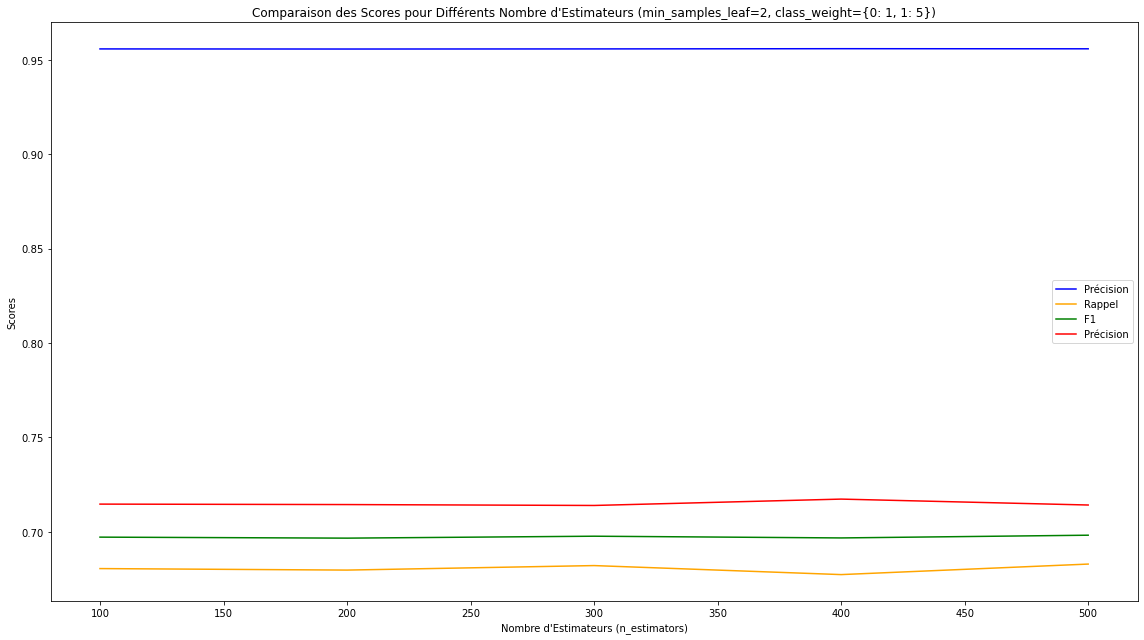

In [10]:
# Filtrer les données en fonction des valeurs spécifiques de 'min_samples_leaf' et 'class_weight'
data = score_df[(score_df['min_samples_leaf'] == 2) & (score_df['class_weight'] == "{0: 1, 1: 5}")]

# Créer un graphique avec les données filtrées
plt.figure(figsize=(16, 9))
plt.plot(data['n_estimators'], data['Accuracy'], label='Précision', color='blue')
plt.plot(data['n_estimators'], data['Recall'], label='Rappel', color='orange')
plt.plot(data['n_estimators'], data['F1'], label='F1', color='green')
plt.plot(data['n_estimators'], data['Precision'], label='Précision', color='red')
plt.xlabel('Nombre d\'Estimateurs (n_estimators)')
plt.ylabel('Scores')
plt.title('Comparaison des Scores pour Différents Nombre d\'Estimateurs (min_samples_leaf=2, class_weight={0: 1, 1: 5})')
plt.tight_layout()
plt.legend()
plt.show()


## influence du min_samples_leaf

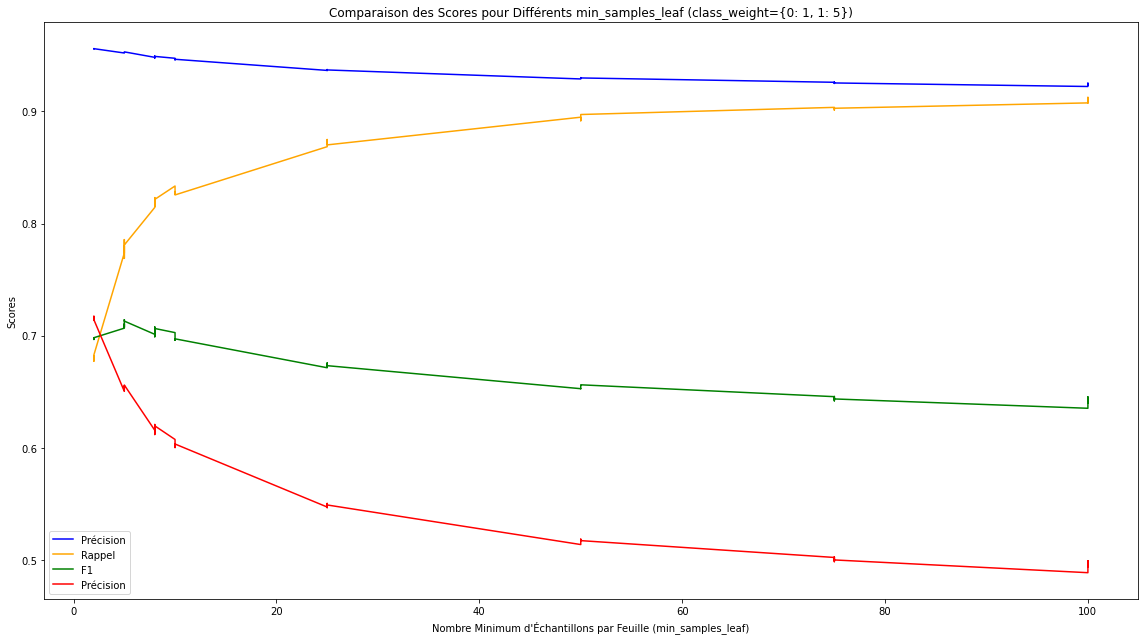

In [11]:
# Fixer la valeur de 'class_weight'
class_weight_value = "{0: 1, 1: 5}"

# Filtrer les données en fonction de la valeur fixée de 'class_weight'
data = score_df[score_df['class_weight'] == class_weight_value]

# Créer un graphique en faisant varier 'min_samples_leaf'
plt.figure(figsize=(16, 9))
plt.plot(data['min_samples_leaf'], data['Accuracy'], label='Précision', color='blue')
plt.plot(data['min_samples_leaf'], data['Recall'], label='Rappel', color='orange')
plt.plot(data['min_samples_leaf'], data['F1'], label='F1', color='green')
plt.plot(data['min_samples_leaf'], data['Precision'], label='Précision', color='red')
plt.xlabel('Nombre Minimum d\'Échantillons par Feuille (min_samples_leaf)')
plt.ylabel('Scores')
plt.title(f'Comparaison des Scores pour Différents min_samples_leaf (class_weight={class_weight_value})')
plt.tight_layout()
plt.legend()
plt.show()


## Influence du class_weight

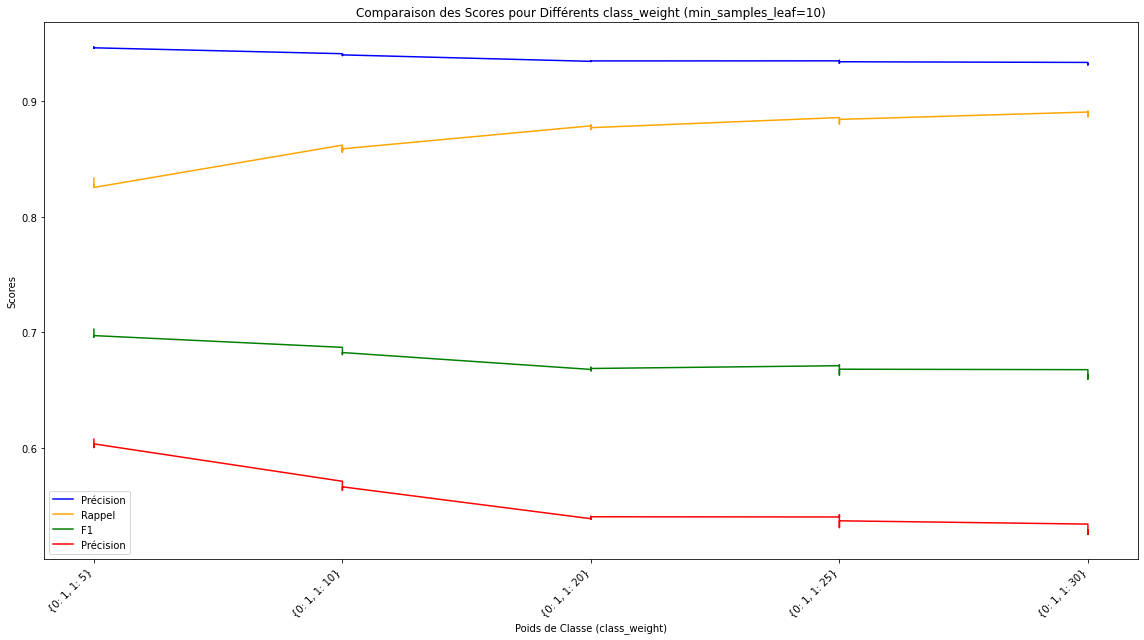

In [13]:
# Fixer la valeur de 'min_samples_leaf'
min_samples_leaf_value = 10

# Filtrer les données en fonction de la valeur fixée de 'min_samples_leaf'
data = score_df[score_df['min_samples_leaf'] == min_samples_leaf_value]

# Créer un graphique en faisant varier 'class_weight'
plt.figure(figsize=(16, 9))
plt.plot(data['class_weight'], data['Accuracy'], label='Précision', color='blue')
plt.plot(data['class_weight'], data['Recall'], label='Rappel', color='orange')
plt.plot(data['class_weight'], data['F1'], label='F1', color='green')
plt.plot(data['class_weight'], data['Precision'], label='Précision', color='red')
plt.xlabel('Poids de Classe (class_weight)')
plt.ylabel('Scores')
plt.title(f'Comparaison des Scores pour Différents class_weight (min_samples_leaf={min_samples_leaf_value})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()


# Etude de l'influence du paramètre min_weight_fraction_leaf

In [83]:
# Sélection des colonnes à utiliser tout sauf 'date' et 'gelee_blanche_vehicule_presence'
features = [col for col in df_merged0.columns if col not in ["date", "gelee_blanche_vehicule_presence",'u10','v10']]

# Définir les valeurs de min_weight_fraction_leaf à tester
#min_weight_fraction_leaf_options = [1e-5, 2.5e-5, 5e-5, 7.5e-5, 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3]
min_weight_fraction_leaf_options = [1e-3,1.5e-3,2e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2] 
# Liste pour stocker les résultats des scores
results = []

# Fixer class_weight à "balanced"
class_weight_value = "balanced"

# Boucle pour les valeurs de min_weight_fraction_leaf
for min_weight_fraction_leaf in min_weight_fraction_leaf_options:
    all_y_true = []
    all_y_pred = []

    # Boucle pour les combinaisons de données d'entraînement et de test
    for train_num, (train_df, test_df) in enumerate([(concatenated_df0, df_merged2), (concatenated_df1, df_merged0), (concatenated_df2, df_merged1)], start=1):
        # Préparation des données
        X_train_e = train_df[features]
        y_train_e = train_df["gelee_blanche_vehicule_presence"]
        X_test_e = test_df[features]
        y_test_e = test_df["gelee_blanche_vehicule_presence"]

        # Création du modèle avec min_weight_fraction_leaf
        model = RandomForestClassifier(n_jobs=10, class_weight=class_weight_value, min_weight_fraction_leaf=min_weight_fraction_leaf)
        model.fit(X_train_e, y_train_e)

        # Prédiction sur l'ensemble de test
        y_pred_e = model.predict(X_test_e)

        # Stockage des vraies valeurs et des prédictions
        all_y_true.extend(y_test_e)
        all_y_pred.extend(y_pred_e)

    # Calcul des scores pour cette combinaison d'hyperparamètres
    accuracy = accuracy_score(all_y_true, all_y_pred)
    recall = recall_score(all_y_true, all_y_pred, pos_label=1)
    f1 = f1_score(all_y_true, all_y_pred, pos_label=1)
    precision = precision_score(all_y_true, all_y_pred, pos_label=1)

    # Stockage des scores pour cette combinaison d'hyperparamètres
    results.append([class_weight_value, min_weight_fraction_leaf, accuracy, recall, f1, precision])

# Créer un DataFrame contenant les scores
score_columns = ["class_weight", "min_weight_fraction_leaf", "Accuracy", "Recall", "F1", "Precision"]
score_df = pd.DataFrame(results, columns=score_columns)
score_df['class_weight'] = score_df['class_weight'].astype(str)


In [85]:
score_df

,class_weight,min_weight_fraction_leaf,Accuracy,Recall,F1,Precision
0,balanced,0.0010,0.942069,0.848606,0.686211,0.575987
1,balanced,0.0015,0.936597,0.870916,0.672202,0.547321
2,balanced,0.0020,0.933682,0.885259,0.665868,0.533622
3,balanced,0.0025,0.931006,0.894024,0.659224,0.522103
4,balanced,0.0050,0.920478,0.929084,0.635596,0.483016
5,balanced,0.0075,0.915066,0.948207,0.625000,0.466118
6,balanced,0.0100,0.909832,0.945817,0.610283,0.450474


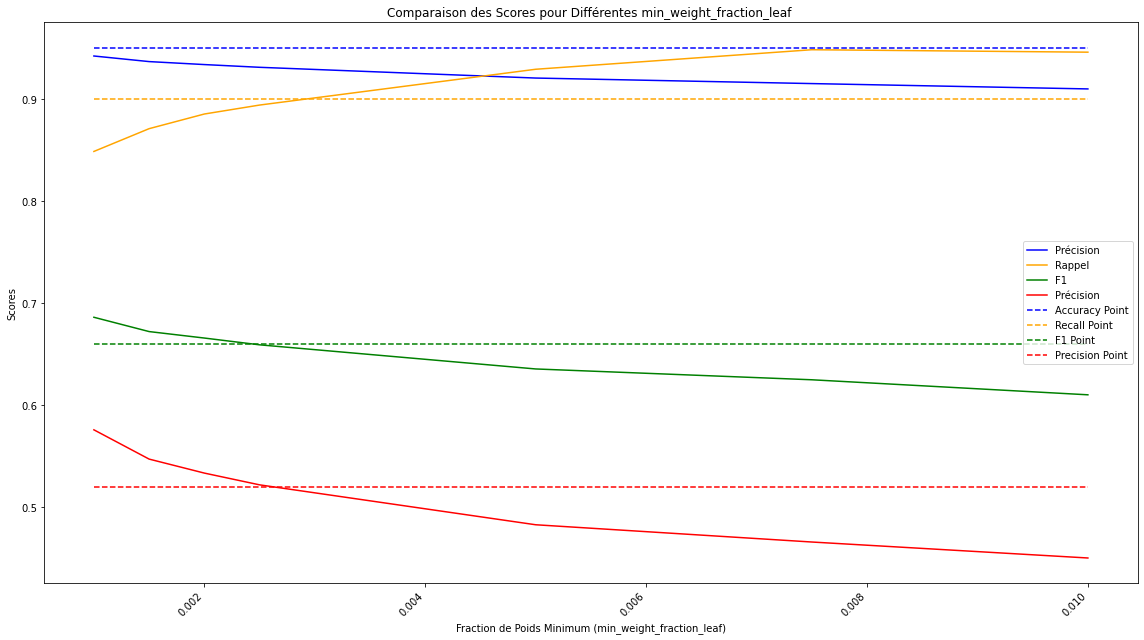

In [84]:
data = score_df
hyperparameters = data['min_weight_fraction_leaf']
# Créer un graphique en faisant varier 'min_weight_fraction_leaf'
plt.figure(figsize=(16, 9))                                                                   
plt.plot(data['min_weight_fraction_leaf'], data['Accuracy'], label='Précision', color='blue')
plt.plot(data['min_weight_fraction_leaf'], data['Recall'], label='Rappel', color='orange')
plt.plot(data['min_weight_fraction_leaf'], data['F1'], label='F1', color='green')
plt.plot(data['min_weight_fraction_leaf'], data['Precision'], label='Précision', color='red')

plt.hlines(y=0.95, xmin=hyperparameters.min(), xmax=hyperparameters.max(), color='blue', linestyles='dashed', label='Accuracy Point')
plt.hlines(y=0.9, xmin=hyperparameters.min(), xmax=hyperparameters.max(), color='orange', linestyles='dashed', label='Recall Point')
plt.hlines(y=0.66, xmin=hyperparameters.min(), xmax=hyperparameters.max(), color='green', linestyles='dashed', label='F1 Point')
plt.hlines(y=0.52, xmin=hyperparameters.min(), xmax=hyperparameters.max(), color='red', linestyles='dashed', label='Precision Point')

plt.xlabel('Fraction de Poids Minimum (min_weight_fraction_leaf)')
plt.ylabel('Scores')
plt.title('Comparaison des Scores pour Différentes min_weight_fraction_leaf ')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.show()

## Analyse et interprétation 

Au terme de la validation croisée nous constatons que ce qui influence effectivement la performance du modèle est le paramètre min_sample_leaf  :
- plus il est petit meilleur est la précision 
- plus il est grand meilleur est le recall 


Nous constatons que le paramètre n_estimators n'a pas une réelle importance sur les performance du modèle. 
En effet nous n'observons pas une réelle variation des performances lorsque le nombre d'estimateurs varie.
Nous allons le fixer donc à une valeur par de 100 pour tous nos modèles.


- ` n_estimators = 100`

Nous faisons tout de même varier les poids des classes.

et nous constatons qu'il influence le modèle de la même façon que min_simple_leaf , mais l'impact reste très léger

## Random forest avec meilleurs hyperparamètres : maximisation de la précision sur la classe 1.
Pour le modèle suivant on a une Précision maximale :et un score f1  >=  à celui des prévis.

Donc on le choisis pour la maximisation de la précision.

     Définir les hyperparamètres à tester  : maximisation de la Précision (classe = 1)
     class_weight_options = [{0: 1, 1: 5},{0: 1, 1: 10},{0: 1, 1: 20},{0: 1, 1: 30}]
     min_samples_leaf_options = [2,5,8,10]
     n_estimators_options = [100, 200, 300,400,500]

![Capture d'écran](../images/modele_rf_precision_max.png)



# Test du modèle sur les données de test

In [60]:
class_weights = {0: 1, 1: 5}
min_samples_leaf = 2
n_estimators = 100


rfp = RandomForestClassifier(class_weight=class_weights, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators,n_jobs=10)

# Entraînez le modèle sur les données d'entraînement
rfp.fit(X_train, y_train)

# Prédisez les étiquettes sur les données de test
y_pred1 = rfp.predict(X_test)

Matrice de confusion : 


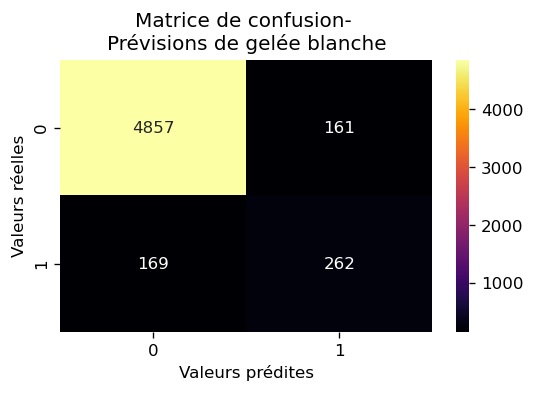



Rapport de classification : 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5018
           1       0.62      0.61      0.61       431

    accuracy                           0.94      5449
   macro avg       0.79      0.79      0.79      5449
weighted avg       0.94      0.94      0.94      5449



In [61]:
# Calculez la matrice de confusion
conf1 = confusion_matrix(y_test,y_pred1)
print("Matrice de confusion : ")
plt.figure(figsize=(5, 3),dpi=120)
sns.heatmap(conf1, annot=True, fmt="d", cmap="inferno")
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion- \nPrévisions de gelée blanche')
plt.show()
print('\n')
print('Rapport de classification : ')
print(classification_report(y_test, y_pred1))


## Random forest avec meilleurs hyperparamètres : maximisation du recall sur la classe 1.

Pour le modèle suivant , on a un recall de 0.96 et un score f1 de 0.52 


Donc on le choisis pour la maximisation de la précision. 

     Définir les hyperparamètres à tester  : maximisation du recall (classe = 1)

    class_weight_options = [{0: 1, 1: 5},{0: 1, 1: 10},{0: 1, 1: 25}]
    min_samples_leaf_options = [25,50,75,100]
    n_estimators_options = [100, 200, 300]

![Capture d'écran](../images/modele_rf_recall_max.PNG)



## Test avec les données de test

In [7]:
class_weights = {0: 1, 1: 25}
min_samples_leaf = 25
n_estimators = 100


rfr = RandomForestClassifier(class_weight=class_weights, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators,n_jobs=10)

# Entraînez le modèle sur les données d'entraînement
rfr.fit(X_train, y_train)

# Prédisez les étiquettes sur les données de test
y_pred2 = rfr.predict(X_test)

Matrice de confusion : 


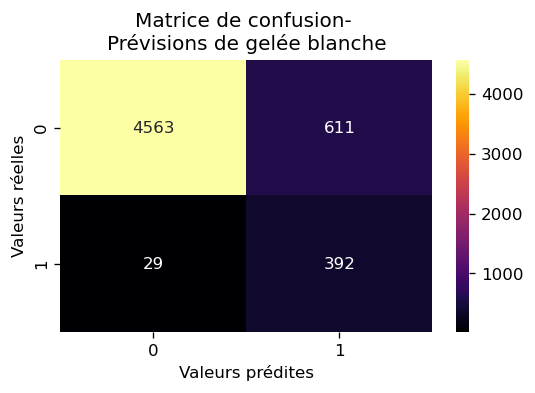



Rapport de classification : 
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      5174
           1       0.39      0.93      0.55       421

    accuracy                           0.89      5595
   macro avg       0.69      0.91      0.74      5595
weighted avg       0.95      0.89      0.91      5595



In [30]:
conf2 = confusion_matrix(y_test,y_pred2)
# Calculez la matrice de confusion
print("Matrice de confusion : ")
plt.figure(figsize=(5, 3),dpi=120)
sns.heatmap(conf2, annot=True, fmt="d", cmap="inferno")
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion- \nPrévisions de gelée blanche')
plt.show()
print('\n')
print('Rapport de classification : ')
print(classification_report(y_test, y_pred2))

## Importance des Hyperparamètres 

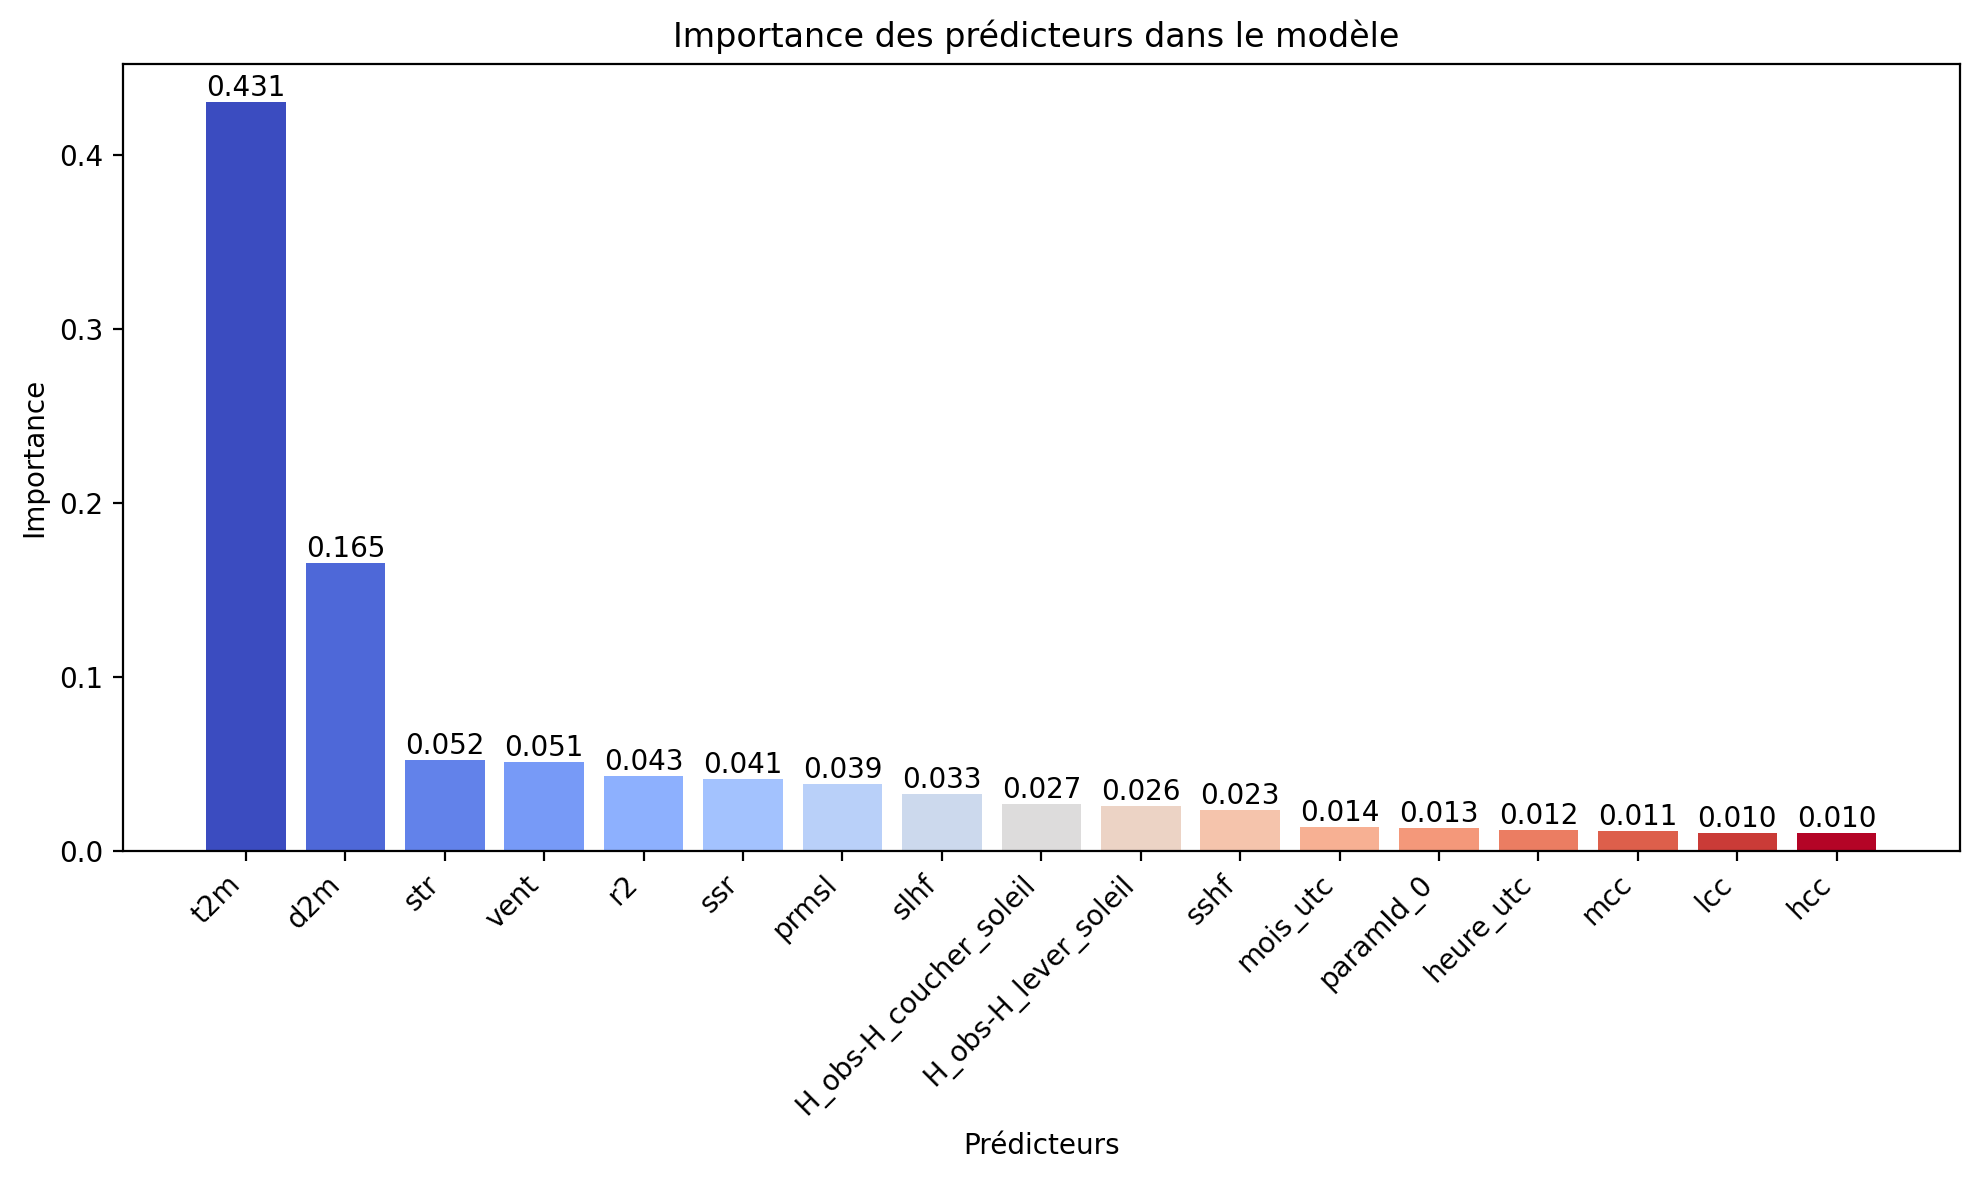

In [62]:
# Obtenir l'importance des prédicteurs
importances = rfp.feature_importances_

# Créer un DataFrame pour stocker les importances des prédicteurs avec leurs noms
feature_importances = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})

# Trier les prédicteurs par importance décroissante
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Créer une échelle de couleurs allant du bleu au rouge en fonction des importances
colors = plt.cm.coolwarm(np.linspace(0, 1, len(feature_importances)))

# Tracer le graphique d'importance des prédicteurs avec la coloration par niveau d'importance
plt.figure(figsize=(10, 6), dpi = 200)
plt.bar(feature_importances["Feature"], feature_importances["Importance"], color=colors)
plt.xlabel("Prédicteurs")
plt.ylabel("Importance")
plt.title("Importance des prédicteurs dans le modèle ")
plt.xticks(rotation=45, ha="right")


# Annoter les barres avec les valeurs d'importance
for index, value in enumerate(feature_importances["Importance"]):
    plt.annotate(f"{value:.3f}", (index, value), ha="center", va="bottom")

plt.tight_layout()
plt.show()



   ##  Accuracy, Recall, Precision, F1 : par échéance


/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classi

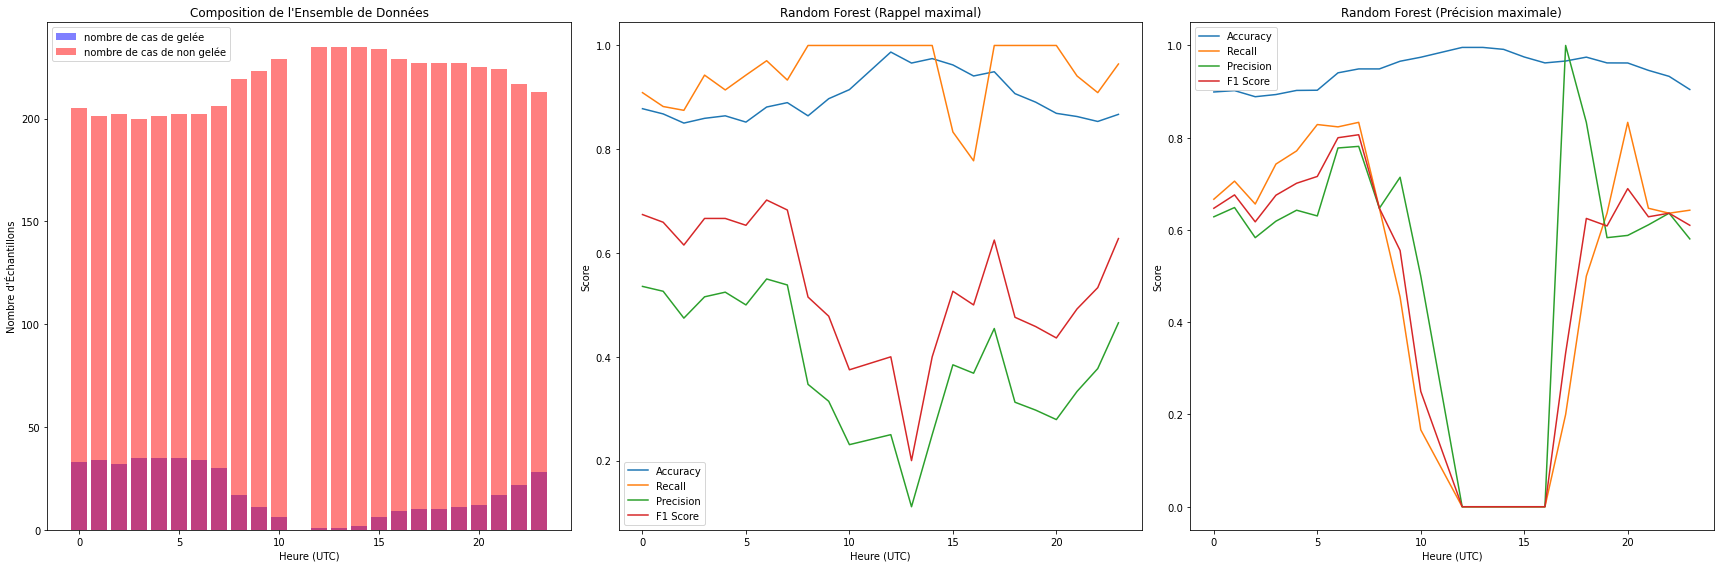

In [12]:
# Créer un DataFrame pour stocker les scores par échéance
scores_df_rfp = pd.DataFrame(columns=['heure_utc', 'accuracy', 'recall', 'precision', 'f1_score'])
scores_df_rfr = pd.DataFrame(columns=['heure_utc', 'accuracy', 'recall', 'precision', 'f1_score'])

# Créer un DataFrame pour stocker la composition de l'ensemble de données
data_composition_df = pd.DataFrame(columns=['heure_utc', 'positive_samples', 'negative_samples'])

# Parcourir les heures de 0 à 23
for heure in range(24):
    # Sélectionner les indices pour cette échéance
    subset_indices = X_test[X_test['heure_utc'] == heure].index
    
    # Vérifier si subset_indices est vide
    if len(subset_indices) == 0:
        continue  # Passe à la prochaine échéance si aucun échantillon n'est disponible
    
    subset_X_test = X_test.loc[subset_indices]
    subset_y_test = y_test.loc[subset_indices]
    
    # Prédire les étiquettes pour ce sous-ensemble d'heures (modèle rfp)
    subset_y_pred_rfp = rfp.predict(subset_X_test)
    
    # Prédire les étiquettes pour ce sous-ensemble d'heures (modèle rfr)
    subset_y_pred_rfr = rfr.predict(subset_X_test)
    
    # Calculer les scores (modèle rfp)
    accuracy_rfp = accuracy_score(subset_y_test, subset_y_pred_rfp)
    recall_rfp = recall_score(subset_y_test, subset_y_pred_rfp, pos_label=1)
    precision_rfp = precision_score(subset_y_test, subset_y_pred_rfp, pos_label=1)
    f1_rfp = f1_score(subset_y_test, subset_y_pred_rfp, pos_label=1)
    
    # Ajouter les scores au DataFrame (modèle rfp)
    scores_df_rfp = scores_df_rfp.append({'heure_utc': heure, 'accuracy': accuracy_rfp, 'recall': recall_rfp, 'precision': precision_rfp, 'f1_score': f1_rfp}, ignore_index=True)
    
    # Calculer les scores (modèle rfr)
    accuracy_rfr = accuracy_score(subset_y_test, subset_y_pred_rfr)
    recall_rfr = recall_score(subset_y_test, subset_y_pred_rfr, pos_label=1)
    precision_rfr = precision_score(subset_y_test, subset_y_pred_rfr, pos_label=1)
    f1_rfr = f1_score(subset_y_test, subset_y_pred_rfr, pos_label=1)
    
    # Ajouter les scores au DataFrame (modèle rfr)
    scores_df_rfr = scores_df_rfr.append({'heure_utc': heure, 'accuracy': accuracy_rfr, 'recall': recall_rfr, 'precision': precision_rfr, 'f1_score': f1_rfr}, ignore_index=True)
    
    # Calculer la composition de l'ensemble de données
    positive_samples = sum(subset_y_test == 1)
    negative_samples = sum(subset_y_test == 0)
    
    # Ajouter la composition de l'ensemble de données au DataFrame
    data_composition_df = data_composition_df.append({'heure_utc': heure, 'positive_samples': positive_samples, 'negative_samples': negative_samples}, ignore_index=True)

# Créer une figure avec trois sous-graphiques côte à côte
fig, (ax3, ax2, ax1) = plt.subplots(1, 3, figsize=(24, 8))

# Plot pour le modèle rfp
ax1.plot(scores_df_rfp['heure_utc'], scores_df_rfp['accuracy'], label='Accuracy')
ax1.plot(scores_df_rfp['heure_utc'], scores_df_rfp['recall'], label='Recall')
ax1.plot(scores_df_rfp['heure_utc'], scores_df_rfp['precision'], label='Precision')
ax1.plot(scores_df_rfp['heure_utc'], scores_df_rfp['f1_score'], label='F1 Score')
ax1.set_title('Random Forest (Précision maximale)')
ax1.set_xlabel('Heure (UTC)')
ax1.set_ylabel('Score')
ax1.legend()

# Plot pour le modèle rfr
ax2.plot(scores_df_rfr['heure_utc'], scores_df_rfr['accuracy'], label='Accuracy')
ax2.plot(scores_df_rfr['heure_utc'], scores_df_rfr['recall'], label='Recall')
ax2.plot(scores_df_rfr['heure_utc'], scores_df_rfr['precision'], label='Precision')
ax2.plot(scores_df_rfr['heure_utc'], scores_df_rfr['f1_score'], label='F1 Score')
ax2.set_title('Random Forest (Rappel maximal)')
ax2.set_xlabel('Heure (UTC)')
ax2.set_ylabel('Score')
ax2.legend()

# Plot pour la composition de l'ensemble de données
ax3.bar(data_composition_df['heure_utc'], data_composition_df['positive_samples'], label='nombre de cas de gelée ', color='blue', alpha=0.5)
ax3.bar(data_composition_df['heure_utc'], data_composition_df['negative_samples'], label='nombre de cas de non gelée', color='red', alpha=0.5)
ax3.set_title('Composition de l\'Ensemble de Données')
ax3.set_xlabel('Heure (UTC)')
ax3.set_ylabel('Nombre d\'Échantillons')
ax3.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()


/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/labia/tchoffoc/.local/lib/python3.7/site-packages/sklearn

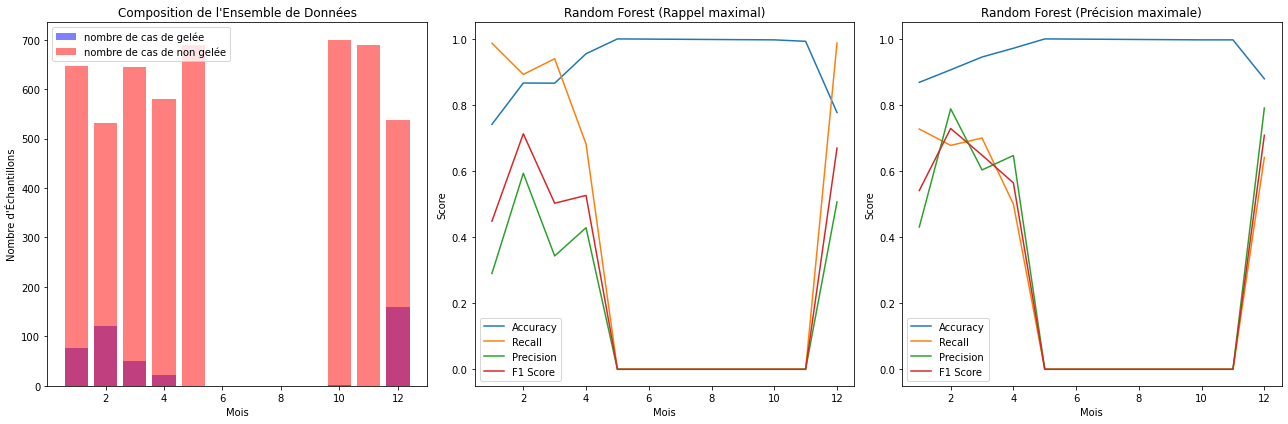

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Créer un DataFrame pour stocker les scores par mois
scores_df_rfp = pd.DataFrame(columns=['mois_utc', 'accuracy', 'recall', 'precision', 'f1_score'])
scores_df_rfr = pd.DataFrame(columns=['mois_utc', 'accuracy', 'recall', 'precision', 'f1_score'])

# Créer un DataFrame pour stocker la composition de l'ensemble de données
data_composition_df = pd.DataFrame(columns=['mois_utc', 'positive_samples', 'negative_samples'])

# Parcourir les mois de 1 à 12
for mois in range(1, 13):
    # Sélectionner les indices pour ce mois
    subset_indices = X_test[X_test['mois_utc'] == mois].index
    
    # Vérifier si subset_indices est vide
    if len(subset_indices) == 0:
        continue  # Passe au mois suivant si aucun échantillon n'est disponible
    
    subset_X_test = X_test.loc[subset_indices]
    subset_y_test = y_test.loc[subset_indices]
    
    # Prédire les étiquettes pour ce sous-ensemble de mois (modèle rfp)
    subset_y_pred_rfp = rfp.predict(subset_X_test)
    
    # Prédire les étiquettes pour ce sous-ensemble de mois (modèle rfr)
    subset_y_pred_rfr = rfr.predict(subset_X_test)
    
    # Calculer les scores (modèle rfp)
    accuracy_rfp = accuracy_score(subset_y_test, subset_y_pred_rfp)
    recall_rfp = recall_score(subset_y_test, subset_y_pred_rfp, pos_label=1)
    precision_rfp = precision_score(subset_y_test, subset_y_pred_rfp, pos_label=1)
    f1_rfp = f1_score(subset_y_test, subset_y_pred_rfp, pos_label=1)
    
    # Ajouter les scores au DataFrame (modèle rfp)
    scores_df_rfp = scores_df_rfp.append({'mois_utc': mois, 'accuracy': accuracy_rfp, 'recall': recall_rfp, 'precision': precision_rfp, 'f1_score': f1_rfp}, ignore_index=True)
    
    # Calculer les scores (modèle rfr)
    accuracy_rfr = accuracy_score(subset_y_test, subset_y_pred_rfr)
    recall_rfr = recall_score(subset_y_test, subset_y_pred_rfr, pos_label=1)
    precision_rfr = precision_score(subset_y_test, subset_y_pred_rfr, pos_label=1)
    f1_rfr = f1_score(subset_y_test, subset_y_pred_rfr, pos_label=1)
    
    # Ajouter les scores au DataFrame (modèle rfr)
    scores_df_rfr = scores_df_rfr.append({'mois_utc': mois, 'accuracy': accuracy_rfr, 'recall': recall_rfr, 'precision': precision_rfr, 'f1_score': f1_rfr}, ignore_index=True)
    
    # Calculer la composition de l'ensemble de données
    positive_samples = sum(subset_y_test == 1)
    negative_samples = sum(subset_y_test == 0)
    
    # Ajouter la composition de l'ensemble de données au DataFrame
    data_composition_df = data_composition_df.append({'mois_utc': mois, 'positive_samples': positive_samples, 'negative_samples': negative_samples}, ignore_index=True)

# Créer une figure avec trois sous-graphiques côte à côte
fig, (ax3, ax2, ax1) = plt.subplots(1, 3, figsize=(18, 6))

# Plot pour le modèle rfp
ax1.plot(scores_df_rfp['mois_utc'], scores_df_rfp['accuracy'], label='Accuracy')
ax1.plot(scores_df_rfp['mois_utc'], scores_df_rfp['recall'], label='Recall')
ax1.plot(scores_df_rfp['mois_utc'], scores_df_rfp['precision'], label='Precision')
ax1.plot(scores_df_rfp['mois_utc'], scores_df_rfp['f1_score'], label='F1 Score')
ax1.set_title('Random Forest (Précision maximale)')
ax1.set_xlabel('Mois')
ax1.set_ylabel('Score')
ax1.legend()

# Plot pour le modèle rfr
ax2.plot(scores_df_rfr['mois_utc'], scores_df_rfr['accuracy'], label='Accuracy')
ax2.plot(scores_df_rfr['mois_utc'], scores_df_rfr['recall'], label='Recall')
ax2.plot(scores_df_rfr['mois_utc'], scores_df_rfr['precision'], label='Precision')
ax2.plot(scores_df_rfr['mois_utc'], scores_df_rfr['f1_score'], label='F1 Score')
ax2.set_title('Random Forest (Rappel maximal)')
ax2.set_xlabel('Mois')
ax2.set_ylabel('Score')
ax2.legend()

# Plot pour la composition de l'ensemble de données (histogrammes)
ax3.bar(data_composition_df['mois_utc'], data_composition_df['positive_samples'], label='nombre de cas de gelée', color='blue', alpha=0.5)
ax3.bar(data_composition_df['mois_utc'], data_composition_df['negative_samples'], label='nombre de cas de non gelée', color='red', alpha=0.5)
ax3.set_title('Composition de l\'Ensemble de Données')
ax3.set_xlabel('Mois')
ax3.set_ylabel('Nombre d\'Échantillons')
ax3.legend()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()
